In [1]:
from torchvision import datasets, transforms
import torch
import os, requests, pathlib , json
from urllib.parse import urlencode
from torch.utils.data import DataLoader, random_split, Subset, Dataset
from torchvision import datasets, transforms
import numpy as np

In [2]:
def _compute_mean_std(loader):
    """Media y STD por canal en [0,1]."""
    mean = torch.zeros(3)
    sqmean = torch.zeros(3)
    n_pix = 0
    for xb, _ in loader:
        b, c, h, w = xb.shape
        xb = xb.view(b, c, -1)
        mean += xb.mean(dim=(0,2)) * b
        sqmean += (xb**2).mean(dim=(0,2)) * b
        n_pix += b
    mean /= n_pix
    var = sqmean / n_pix - mean**2
    std = var.clamp_min(1e-12).sqrt()
    return mean.tolist(), std.tolist()

def _compute_median_mad(loader, max_batches=None):
    """Mediana y MAD por canal (robusto). Ojo: usa muestreo; ajusta max_batches si quieres exactitud."""
    chans = [[], [], []]
    seen = 0
    for xb, _ in loader:
        xb = xb.clamp(0,1).cpu()
        b, c, h, w = xb.shape
        sample = xb.permute(0,2,3,1).reshape(-1, c)
        idx = torch.randperm(sample.size(0))[: min(10000, sample.size(0))]
        samp = sample[idx]  # [K,3]
        for j in range(3):
            chans[j].append(samp[:, j])
        seen += 1
        if max_batches and seen >= max_batches:
            break
    chans = [torch.cat(chs) for chs in chans]
    med = [torch.median(ch).item() for ch in chans]
    mad = [torch.median((ch - med[j]).abs()).item() for j, ch in enumerate(chans)]
    mad_scaled = [max(1e-6, 1.4826*m) for m in mad]
    return med, mad_scaled

def get_or_make_stats(dataset, cache_path=None, robust=False, tmp_bs=64, num_workers=2):
    """
    dataset: Dataset SIN Normalize.
    robust: False -> (mean,std), True -> (median, MAD*1.4826).
    cache_path: JSON opcional para cachear.
    """
    if cache_path:
        try:
            if os.path.exists(cache_path) and os.path.getsize(cache_path) > 0:
                with open(cache_path, "r") as f:
                    d = json.load(f)
                if d.get("robust", False) == robust and "loc" in d and "scale" in d:
                    return d["loc"], d["scale"]
        except (JSONDecodeError, OSError, KeyError, ValueError) as e:
            print(f"[WARN] Ignorando cache de stats corrupto en '{cache_path}': {e}")

    tmp_loader = DataLoader(dataset, batch_size=tmp_bs, shuffle=False, num_workers=num_workers)
    if robust:
        loc, scale = _compute_median_mad(tmp_loader, max_batches=200)
    else:
        loc, scale = _compute_mean_std(tmp_loader)

    if cache_path:
        try:
            os.makedirs(os.path.dirname(cache_path), exist_ok=True)
            tmp_file = cache_path + ".tmp"
            with open(tmp_file, "w") as f:
                json.dump({"robust": robust, "loc": loc, "scale": scale}, f, indent=2)
            os.replace(tmp_file, cache_path)
        except OSError as e:
            print(f"[WARN] No se pudo escribir cache de stats en '{cache_path}': {e}")

    return loc, scale

class OxfordPetsBinary(torch.utils.data.Dataset):
    """
    0 = cat, 1 = dog. Funciona si base_ds es OxfordIIITPet o un Subset de él.
    """
    def __init__(self, base_ds):
        if isinstance(base_ds, torch.utils.data.Subset):
            self.base = base_ds.dataset
            self.indices = list(base_ds.indices)
        else:
            self.base = base_ds
            self.indices = None

        self._species_by_base_index = None
        try:
            anns = getattr(self.base, "_anns", None)
            imgs = getattr(self.base, "images", None) or getattr(self.base, "_images", None)
            if anns is not None and imgs is not None:
                self._species_by_base_index = {}
                for i in range(len(self.base)):
                    path, _ = imgs[i]
                    fname = path.split("/")[-1].split(".")[0]
                    sp = anns.get(fname, {}).get("species", None)
                    self._species_by_base_index[i] = sp
        except Exception:
            self._species_by_base_index = None

        self._name_is_cat = None
        if self._species_by_base_index is None:
            cat_breeds = {
                "abyssinian","bengal","birman","bombay","british_shorthair",
                "egyptian_mau","maine_coon","persian","ragdoll",
                "russian_blue","siamese","sphynx" }

            classes = getattr(self.base, "classes", [str(i) for i in range(37)])
            self._name_is_cat = [1 if c.replace(" ", "_").lower() in cat_breeds else 0 for c in classes]

    def __len__(self):
        return len(self.indices) if self.indices is not None else len(self.base)

    def __getitem__(self, idx):

        base_idx = self.indices[idx] if self.indices is not None else idx
        x, y_breed = self.base[base_idx]

        if self._species_by_base_index is not None and self._species_by_base_index.get(base_idx) in (1, 2):
            y_bin = 0 if self._species_by_base_index[base_idx] == 1 else 1
        else:
            is_cat = self._name_is_cat[y_breed]
            y_bin = 0 if is_cat == 1 else 1
        return x, y_bin


def make_transforms(loc, scale, img_size=224, aug=True):
    norm = transforms.Normalize(mean=loc, std=scale)
    if aug:
        tf = transforms.Compose([
            transforms.Resize(int(img_size*1.14)),
            transforms.RandomResizedCrop(img_size, scale=(0.6, 1.0)),
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.ColorJitter(0.2,0.2,0.2,0.1),
            transforms.ToTensor(),
            norm])
    else:
        tf = transforms.Compose([
            transforms.Resize(int(img_size*1.14)),
            transforms.CenterCrop(img_size),
            transforms.ToTensor(),
            norm])
    return tf

def get_oxford_pet_loaders(
    data_dir="./data", batch_size=32, val_split=0.2, num_workers=2, seed=42,
    mode="multiclass", img_size=224, robust=False, stats_cache_path=None,
    use_cached_if_available=True):

    """
    mode: 'multiclass' (37 razas) | 'binary' (cat vs dog)
    robust=False -> Normaliza con media/STD; True -> mediana/MAD (robusta).
    stats_cache_path: ruta JSON para cachear loc/scale.
    """

    tf_tmp = transforms.Compose([
        transforms.Resize(int(img_size*1.14)),
        transforms.CenterCrop(img_size),
        transforms.ToTensor()])

    base_trainval_tmp = datasets.OxfordIIITPet(
        root=data_dir, split="trainval", target_types="category",
        download=True, transform=tf_tmp)

    loc, scale = get_or_make_stats(base_trainval_tmp,
        cache_path=stats_cache_path if use_cached_if_available else None,
        robust=robust, tmp_bs=64, num_workers=num_workers)

    tf_train = make_transforms(loc, scale, img_size=img_size, aug=True)
    tf_val = make_transforms(loc, scale, img_size=img_size, aug=False)


    base_trainval = datasets.OxfordIIITPet(
        root=data_dir, split="trainval", target_types="category",
        download=False, transform=tf_train)

    base_valview = datasets.OxfordIIITPet(
        root=data_dir, split="trainval", target_types="category",
        download=False, transform=tf_val)

    g = torch.Generator().manual_seed(seed)
    val_size = int(len(base_trainval) * val_split)
    train_size = len(base_trainval) - val_size
    idx_train, idx_val = random_split(range(len(base_trainval)), [train_size, val_size], generator=g)

    if mode == "binary":
        train_ds = OxfordPetsBinary(Subset(base_trainval, idx_train.indices))
        val_ds   = OxfordPetsBinary(Subset(base_valview, idx_val.indices))
        class_names, num_classes = ["cat", "dog"], 2

    elif mode == "multiclass":
        train_ds = Subset(base_trainval, idx_train.indices)
        val_ds   = Subset(base_valview, idx_val.indices)
        class_names = getattr(base_trainval, "classes", list(range(37)))
        num_classes = 37
    else:
        raise ValueError("mode debe ser 'binary' o 'multiclass'.")

    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True,  num_workers=num_workers, pin_memory=True)
    val_loader   = DataLoader(val_ds,   batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True)

    return train_loader, val_loader, class_names, num_classes, (loc, scale)


In [3]:

train_loader, val_loader, class_names, num_classes, (mean, std) = get_oxford_pet_loaders(
    data_dir="./data",
    batch_size=32,
    val_split=0.2,
    num_workers=2,
    seed=42,
    mode="binary",
    img_size=224,
    robust=False,
    stats_cache_path="./data/pet_stats.json",
    use_cached_if_available=True)

print("mean:", mean, "std:", std)

100%|██████████| 792M/792M [00:26<00:00, 30.2MB/s]
100%|██████████| 19.2M/19.2M [00:01<00:00, 15.9MB/s]


mean: [0.48293063044548035, 0.44492557644844055, 0.3957090973854065] std: [0.2592383325099945, 0.25327032804489136, 0.2598187029361725]


In [4]:
images, labels = next(iter(train_loader))
print(f"Batch shape: {images.shape}")
print(f"Labels shape: {labels.shape}")

Batch shape: torch.Size([32, 3, 224, 224])
Labels shape: torch.Size([32])


In [ ]:

def download_inat_species(taxon_name, out_dir, n=200):
    os.makedirs(out_dir, exist_ok=True)

    params = {"taxon_name": taxon_name,
        "has[photos]": "true",
        "quality_grade": "research",
        "per_page": 200,
        "page": 1,
        "order_by": "votes"}

    got = 0
    while got < n:
        url = f"https://api.inaturalist.org/v1/observations?{urlencode(params)}"
        r = requests.get(url, timeout=30)
        r.raise_for_status()
        obs = r.json().get("results", [])

        if not obs:
          break

        for o in obs:
            photos = o.get("photos", [])
            if not photos:
              continue

            photo_url = photos[0].get("url", "").replace("square", "medium")

            if not photo_url:
              continue

            fname = f"{o['id']}_{got}.jpg"
            p = pathlib.Path(out_dir)/fname

            try:
                img = requests.get(photo_url, timeout=30)
                img.raise_for_status()
                p.write_bytes(img.content)
                got += 1
                if got >= n: break
            except Exception:
                pass

        params["page"] += 1
    return got

root = "./data/inat2"
cats = download_inat_species("Felis catus", os.path.join(root, "cat"), n=5000)
dogs = download_inat_species("Canis lupus familiaris", os.path.join(root, "dog"), n=5000)
print("descargadas:", cats, "gatos y", dogs, "perros")


In [ ]:

def get_inat2_loaders(root="./data/inat2",
    batch_size=32,val_split=0.2,
    num_workers=1,seed=42,augment=True,pin_memory=False,persistent_workers=False):

    """
    Crea DataLoaders (train, val) desde un directorio tipo ImageFolder:
        root/
          cat/
            img1.jpg ...
          dog/
            imgX.jpg ...

    - Split estratificado por clase.
    - Transforms para VGG (224x224) + normalización ImageNet.
    - Devuelve también class_names y class_weights (para CrossEntropy).

    Returns
    -------
    train_loader, val_loader, class_names, class_weights
    """

    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])
    if augment:
        train_tfms = transforms.Compose([
            transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.RandomRotation(10),
            transforms.ColorJitter(brightness=0.15, contrast=0.15, saturation=0.15, hue=0.02),
            transforms.ToTensor(),
            normalize])

    else:
        train_tfms = transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            normalize,])

    val_tfms = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        normalize])

    base = datasets.ImageFolder(root=root)
    class_names = base.classes
    targets = base.targets

    g = torch.Generator().manual_seed(seed)
    idx_per_class = {}
    for c in range(len(class_names)):
        idx = [i for i, y in enumerate(targets) if y == c]
        idx_per_class[c] = torch.tensor(idx)[torch.randperm(len(idx), generator=g)].tolist()

    val_indices = []
    train_indices = []
    for c, idxs in idx_per_class.items():
        n_val = max(1, int(len(idxs) * val_split))
        val_indices.extend(idxs[:n_val])
        train_indices.extend(idxs[n_val:])

    train_ds = datasets.ImageFolder(root=root, transform=train_tfms)
    val_ds   = datasets.ImageFolder(root=root, transform=val_tfms)

    train_subset = Subset(train_ds, train_indices)
    val_subset   = Subset(val_ds,   val_indices)


    n_per_class = []
    for c in range(len(class_names)):
        n_c = sum(base.targets[i] == c for i in train_indices)
        n_per_class.append(n_c)

    total = sum(n_per_class)
    class_weights = torch.tensor([total / (len(class_names) * n) for n in n_per_class], dtype=torch.float)

    train_loader = DataLoader(train_subset,batch_size=batch_size,
        shuffle=True,num_workers=num_workers,pin_memory=pin_memory,
        persistent_workers=persistent_workers if num_workers > 0 else False,drop_last=False)

    val_loader = DataLoader(val_subset,
        batch_size=batch_size,shuffle=False,num_workers=num_workers,
        pin_memory=pin_memory,persistent_workers=persistent_workers if num_workers > 0 else False,drop_last=False)

    return train_loader, val_loader, class_names, class_weights


In [ ]:
train_loader, val_loader, class_names, class_weights = get_inat2_loaders(root="./data/inat2",
    batch_size=64, val_split=0.2, num_workers=1,seed=42)

In [4]:
images, labels = next(iter(train_loader))
print(f"Batch shape: {images.shape}")
print(f"Labels shape: {labels.shape}")

Batch shape: torch.Size([32, 3, 224, 224])
Labels shape: torch.Size([32])


---

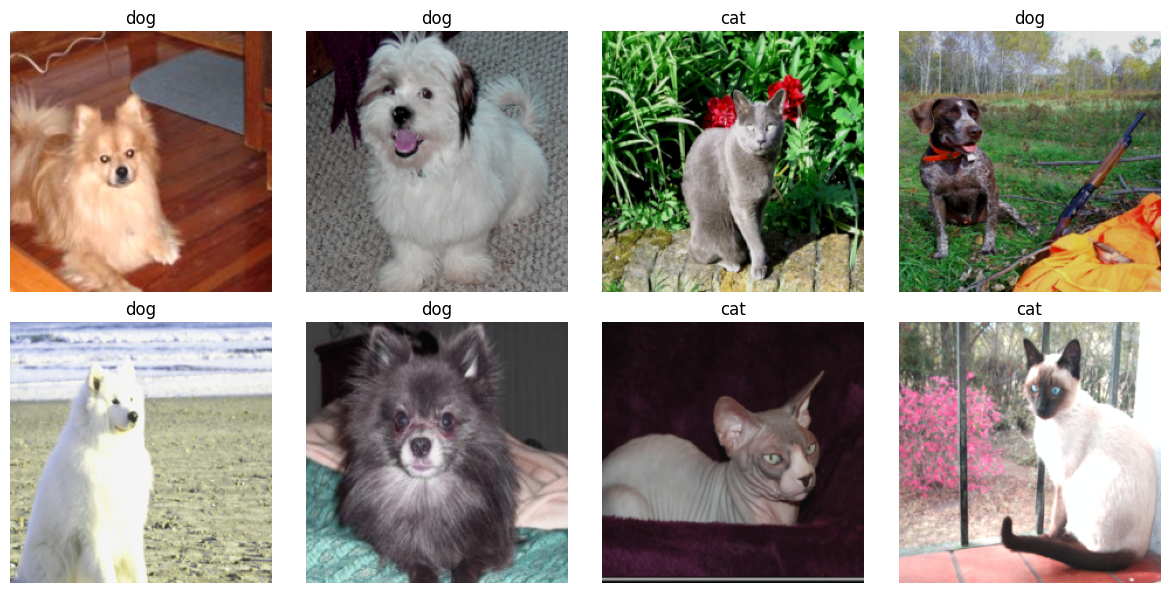

In [5]:
import matplotlib.pyplot as plt
import numpy as np

IMAGENET_MEAN = mean
IMAGENET_STD  = std

def _to_cpu_np(x):
    """Convierte tensores/listas a CPU/NumPy de forma segura."""
    if isinstance(x, torch.Tensor):
        return x.detach().cpu().numpy()
    return np.array(x)

def _denorm(img, mean=IMAGENET_MEAN, std=IMAGENET_STD):
    """img: CxHxW (tensor o np) normalizado -> HxWxC en [0,1]."""
    if isinstance(img, torch.Tensor):
        img = img.detach().cpu().numpy()
    if img.ndim == 3 and img.shape[0] in (1,3):  # CxHxW
        img = img.transpose(1, 2, 0)
    mean = np.array(mean); std = np.array(std)
    img = img * std + mean
    return np.clip(img, 0, 1)

def _safe_label_name(y, class_names=None):
    """
    Acepta: escalar, tensor 0-D, one-hot (1D), lista.
    Devuelve un string seguro para el título.
    """

    if isinstance(y, (np.ndarray, list)) and np.array(y).ndim == 1 and len(y) > 1:
        y_idx = int(np.argmax(y))
    elif isinstance(y, torch.Tensor):
        if y.ndim == 0:  # escalar
            y_idx = int(y.item())
        elif y.ndim == 1 and y.numel() > 1:
            y_idx = int(y.argmax().item())
        else:
            y_idx = int(y.reshape(-1)[0].item())
    else:
        y_idx = int(np.array(y).reshape(-1)[0])

    if class_names is not None and 0 <= y_idx < len(class_names):
        return class_names[y_idx]
    return str(y_idx)

def show_batch(images, labels=None, *, class_names=None, max_images=8,
               mean=IMAGENET_MEAN, std=IMAGENET_STD, figsize=(12,6)):
    """
    Muestra hasta max_images imágenes de un batch, con títulos seguros.
    - images: Tensor [B,C,H,W] o lista de Tensors/ndarrays.
    - labels: opcional (Tensor/list). Soporta escalar por imagen u one-hot.
    - class_names: lista de nombres (opcional).
    """

    if isinstance(images, torch.Tensor):
        B = images.shape[0]
        imgs_list = [images[i] for i in range(B)]
    elif isinstance(images, (list, tuple)):
        imgs_list = list(images)
        B = len(imgs_list)
    else:
        raise TypeError("`images` debe ser Tensor [B,C,H,W] o lista de tensores.")

    lbls_list = None
    if labels is not None:
        if isinstance(labels, dict):
            for k in ('labels', 'label', 'target', 'targets', 'y'):
                if k in labels:
                    labels = labels[k]
                    break
        if isinstance(labels, torch.Tensor):

            if labels.ndim == 0:
                lbls_list = [labels] * B
            elif labels.ndim >= 1:
                if labels.shape[0] != B:
                    m = min(B, labels.shape[0])
                    lbls_list = [labels[i] for i in range(m)]
                    imgs_list = imgs_list[:m]
                    B = m
                else:
                    lbls_list = [labels[i] for i in range(B)]
            else:
                lbls_list = [labels] * B

        elif isinstance(labels, (list, tuple, np.ndarray)):
            labels = list(labels)
            if len(labels) != B:
                m = min(B, len(labels))
                lbls_list = [labels[i] for i in range(m)]
                imgs_list = imgs_list[:m]
                B = m
            else:
                lbls_list = labels
        else:
            lbls_list = None

    n = min(max_images, B)
    if n == 0:
        raise ValueError("Batch vacío: no hay imágenes para mostrar.")

    rows = 2 if n > 4 else 1
    cols = int(np.ceil(n / rows))
    plt.figure(figsize=figsize)

    for i in range(n):
        plt.subplot(rows, cols, i+1)
        img = _denorm(imgs_list[i], mean=mean, std=std)
        plt.imshow(img)
        plt.axis("off")

        if lbls_list is not None:
            try:
                title = _safe_label_name(lbls_list[i], class_names)
            except Exception:
                title = None
        else:
            title = None

        if title is not None:
            plt.title(title)

    plt.tight_layout()
    plt.show()

images, labels = next(iter(train_loader))
show_batch(images, labels, class_names=class_names, max_images=8)

## Model

In [6]:
import torch.nn as nn

def init_vgg_weights(module: nn.Module):
    """
    Aplica la inicialización recomendada para VGG:
      - Conv2d: Kaiming normal (fan_out), bias=0
      - Linear: Kaiming normal (fan_in), bias=0
      - BatchNorm2d: weight=1, bias=0
    """
    if isinstance(module, nn.Conv2d):
        nn.init.kaiming_normal_(module.weight, mode="fan_out", nonlinearity="relu")
        if module.bias is not None:
            nn.init.zeros_(module.bias)
    elif isinstance(module, nn.Linear):
        nn.init.kaiming_normal_(module.weight, mode="fan_in", nonlinearity="relu")
        if module.bias is not None:
            nn.init.zeros_(module.bias)
    elif isinstance(module, nn.BatchNorm2d):
        nn.init.ones_(module.weight)
        nn.init.zeros_(module.bias)

class VGGConvBlock(nn.Module):
    """
    Bloque típico VGG:
      [Conv3x3 -> (BN) -> ReLU] x num_convs  +  (MaxPool 2x2 opcional)

    Args:
        in_channels (int): canales de entrada al bloque.
        out_channels (int): canales de salida de CADA conv del bloque (constantes dentro del bloque).
        num_convs (int): cuántas convs 3x3 apiladas (p.ej., 2 o 3 como en VGG-16/19).
        use_bn (bool): si True, inserta BatchNorm después de cada Conv2d.
        pool (bool): si True, añade MaxPool2d(kernel=2, stride=2) al final.
    """

    def __init__(self, in_channels,
        out_channels, num_convs,*, use_bn = False, pool = True):

        super().__init__()
        layers = []
        c_in = in_channels

        for _ in range(num_convs):
            layers.append(nn.Conv2d(c_in, out_channels, kernel_size=3, padding=1, bias=not use_bn))

            if use_bn:
                layers.append(nn.BatchNorm2d(out_channels))

            layers.append(nn.ReLU(inplace=True))
            c_in = out_channels

        if pool:
            layers.append(nn.MaxPool2d(kernel_size=2, stride=2))

        self.block = nn.Sequential(*layers)
        self.apply(init_vgg_weights)

    def forward(self, x: torch.Tensor):
        return self.block(x)

class VGGDenseBlock(nn.Module):
    """
    Bloque denso típico de VGG:
      Linear -> ReLU -> Dropout

    Args:
        in_features (int)
        out_features (int)
        dropout (float): prob. de Dropout (0.5 clásico en VGG). Si 0.0, no se añade Dropout.
    """

    def __init__(self,in_features,out_features,*,dropout = 0.5):

        super().__init__()
        layers = [
            nn.Linear(in_features, out_features, bias=True),
            nn.ReLU(inplace=True),]

        if dropout and dropout > 0.0:
            layers.append(nn.Dropout(p=dropout))

        self.block = nn.Sequential(*layers)
        self.apply(init_vgg_weights)

    def forward(self, x: torch.Tensor):
        return self.block(x)

In [7]:
class VGG16(nn.Module):
    def __init__(self, num_classes = 2, use_bn = False):
        super().__init__()
        self.features = nn.Sequential(
            VGGConvBlock(3,   64, num_convs=2, use_bn=use_bn, pool=True),   # 224 -> 112
            VGGConvBlock(64, 128, num_convs=2, use_bn=use_bn, pool=True),   # 112 -> 56
            VGGConvBlock(128,256, num_convs=3, use_bn=use_bn, pool=True),   # 56  -> 28
            VGGConvBlock(256,512, num_convs=3, use_bn=use_bn, pool=True),   # 28  -> 14
            VGGConvBlock(512,512, num_convs=3, use_bn=use_bn, pool=True),   # 14  -> 7
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            VGGDenseBlock(512 * 7 * 7, 4096, dropout=0.5),
            VGGDenseBlock(4096, 4096, dropout=0.5),
            nn.Linear(4096, num_classes))

        self.apply(init_vgg_weights)

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x


In [8]:
import math

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
mutli_class = False

if mutli_class:
  model = VGG16(num_classes=37 , use_bn = True).to(device)
else:
  model = VGG16(num_classes=2 , use_bn = True).to(device)


criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.1)


In [9]:
from sklearn.metrics import f1_score
import torch.nn.functional as F

def train_binary_classifier(model,
    train_loader,val_loader,
    criterion,optimizer,scheduler=None,num_epochs=10,device="cuda" , eval=True, multiclass=True):

    """
    Entrena un clasificador binario o multiclase según `multiclass`.

    - multiclass=False:
        * BCEWithLogitsLoss -> salida [B] o [B,1], preds = sigmoid>=0.5
        * CrossEntropyLoss  -> salida [B,2], preds = argmax(1)
        * F1 -> average='binary'

    - multiclass=True:
        * CrossEntropyLoss  -> salida [B,C], preds = argmax(1)
        * F1 -> average='macro'
    """

    model.to(device)
    best_val_acc = 0.0
    history = {}

    train_acc_hist, train_f1_hist = [], []
    val_acc_hist,   val_f1_hist   = [], []

    for epoch in range(num_epochs):
        model.train()
        epoch_loss, correct, total = 0.0, 0, 0
        y_true_train, y_pred_train = [], []

        for X, y in train_loader:
            X, y = X.to(device), y.to(device)
            optimizer.zero_grad()

            logits = model(X)

            if not multiclass and isinstance(criterion, torch.nn.BCEWithLogitsLoss):
                # BINARIO con BCE
                if logits.ndim == 2 and logits.shape[1] == 1:
                    logits_ = logits.squeeze(1)
                else:
                    logits_ = logits
                loss = criterion(logits_, y.float())
                preds = (torch.sigmoid(logits_) >= 0.5).long()
            else:
                # CE (binario 2-clases o multiclase C-clases)
                loss = criterion(logits, y.long())
                preds = logits.argmax(dim=1)

            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=5.0)
            optimizer.step()

            batch_size = y.size(0)
            epoch_loss += loss.item() * batch_size
            correct += (preds == y.long()).sum().item()
            total += batch_size

            y_true_train.extend(y.detach().cpu().tolist())
            y_pred_train.extend(preds.detach().cpu().tolist())

        avg_train_loss = epoch_loss / total
        train_acc = correct / total
        avg_tr = "macro" if multiclass else "binary"
        train_f1 = f1_score(y_true_train, y_pred_train, average=avg_tr)

        train_acc_hist.append(train_acc)
        train_f1_hist.append(train_f1)

        if eval:
            model.eval()
            val_loss_sum, val_correct, val_total = 0.0, 0, 0
            y_true_val, y_pred_val = [], []

            with torch.no_grad():
                for Xv, yv in val_loader:
                    Xv, yv = Xv.to(device), yv.to(device)
                    logits_v = model(Xv)

                    if not multiclass and isinstance(criterion, torch.nn.BCEWithLogitsLoss):
                        if logits_v.ndim == 2 and logits_v.shape[1] == 1:
                            logits_v_ = logits_v.squeeze(1)
                        else:
                            logits_v_ = logits_v
                        loss_v = criterion(logits_v_, yv.float())
                        preds_v = (torch.sigmoid(logits_v_) >= 0.5).long()
                    else:
                        loss_v = criterion(logits_v, yv.long())
                        preds_v = logits_v.argmax(dim=1)

                    bs = yv.size(0)
                    val_loss_sum += loss_v.item() * bs
                    val_correct += (preds_v == yv.long()).sum().item()
                    val_total += bs

                    y_true_val.extend(yv.detach().cpu().tolist())
                    y_pred_val.extend(preds_v.detach().cpu().tolist())

            avg_val_loss = val_loss_sum / val_total
            val_acc = val_correct / val_total
            avg_va = "macro" if multiclass else "binary"
            val_f1 = f1_score(y_true_val, y_pred_val, average=avg_va)

            val_acc_hist.append(val_acc)
            val_f1_hist.append(val_f1)

        if scheduler is not None:
            scheduler.step()

        if eval and val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), "best_model.pt")

        if eval:
            print(f"Epoch {epoch+1}/{num_epochs} | "
                f"Train Loss: {avg_train_loss:.4f} | Train Acc: {train_acc:.3f} | Train F1({avg_tr}): {train_f1:.3f} || "
                f"Val Loss: {avg_val_loss:.4f} | Val Acc: {val_acc:.3f} | Val F1({avg_va}): {val_f1:.3f}")

        else:
            print(f"Epoch {epoch+1}/{num_epochs} | "
                f"Train Loss: {avg_train_loss:.4f} | Train Acc: {train_acc:.3f} | Train F1({avg_tr}): {train_f1:.3f}")

        if eval:
            model.load_state_dict(torch.load("best_model.pt"))


    history = {"train_acc": train_acc_hist,"train_f1":  train_f1_hist}

    if eval:
        history.update({"val_acc": val_acc_hist,"val_f1":  val_f1_hist})

    return history, model

In [33]:
history, model = train_binary_classifier(model, train_loader, val_loader, criterion, optimizer, scheduler=scheduler, num_epochs= 20,
                                         multiclass=False , eval = False)

Epoch 1/20 | Train Loss: 0.5762 | Train Acc: 0.705 | Train F1(binary): 0.810
Epoch 2/20 | Train Loss: 0.5736 | Train Acc: 0.702 | Train F1(binary): 0.810
Epoch 3/20 | Train Loss: 0.5807 | Train Acc: 0.695 | Train F1(binary): 0.805
Epoch 4/20 | Train Loss: 0.5819 | Train Acc: 0.707 | Train F1(binary): 0.812
Epoch 5/20 | Train Loss: 0.5753 | Train Acc: 0.703 | Train F1(binary): 0.810
Epoch 6/20 | Train Loss: 0.5747 | Train Acc: 0.703 | Train F1(binary): 0.811
Epoch 7/20 | Train Loss: 0.5769 | Train Acc: 0.708 | Train F1(binary): 0.812
Epoch 8/20 | Train Loss: 0.5713 | Train Acc: 0.712 | Train F1(binary): 0.816
Epoch 9/20 | Train Loss: 0.5754 | Train Acc: 0.701 | Train F1(binary): 0.809
Epoch 10/20 | Train Loss: 0.5776 | Train Acc: 0.701 | Train F1(binary): 0.809
Epoch 11/20 | Train Loss: 0.5725 | Train Acc: 0.704 | Train F1(binary): 0.810
Epoch 12/20 | Train Loss: 0.5620 | Train Acc: 0.716 | Train F1(binary): 0.818
Epoch 13/20 | Train Loss: 0.5774 | Train Acc: 0.716 | Train F1(binary): 0

In [34]:
def save_checkpoint(model, optimizer, scheduler, epoch, best_val_acc, path="checkpoint.pth"):
    checkpoint = {
        "epoch": epoch,
        "model_state": model.state_dict(),
        "optimizer_state": optimizer.state_dict(),
        "scheduler_state": scheduler.state_dict() if scheduler else None,
        "best_val_acc": best_val_acc,}
    torch.save(checkpoint, path)
    print(f"Checkpoint guardado en {path}")

def load_checkpoint(model, optimizer=None, scheduler=None, path="checkpoint.pth", device="cuda"):
    checkpoint = torch.load(path, map_location=device)

    model.load_state_dict(checkpoint["model_state"])
    if optimizer:
        optimizer.load_state_dict(checkpoint["optimizer_state"])
    if scheduler and checkpoint["scheduler_state"] is not None:
        scheduler.load_state_dict(checkpoint["scheduler_state"])

    epoch = checkpoint["epoch"]
    best_val_acc = checkpoint.get("best_val_acc", None)

    print(f"Checkpoint cargado desde {path}, época {epoch}")
    return epoch, best_val_acc


In [31]:
save_checkpoint(model , optimizer , scheduler , 80 , best_val_acc= np.max(history['train_acc']) , path="checkpoint2.pth")

Checkpoint guardado en checkpoint2.pth


In [32]:
torch.save(model.state_dict(), "modelo2.pth")

In [14]:
from sklearn.metrics import classification_report, roc_curve, auc, roc_auc_score
from sklearn.preprocessing import label_binarize

def evaluate_model(model, val_loader, criterion, *, device="cuda", multiclass=False, plot=True):
    model.eval()
    model.to(device)
    y_true, y_pred = [], []
    y_score_all = []
    loss_sum, n_total = 0.0, 0

    with torch.no_grad():
        for xb, yb in val_loader:
            xb, yb = xb.to(device), yb.to(device)
            logits = model(xb)

            if multiclass:
                probs = torch.softmax(logits, dim=1)
                preds = probs.argmax(dim=1)
                y_score_batch = probs.detach().cpu().numpy()
                loss = criterion(logits, yb.long())
            else:
                if isinstance(criterion, torch.nn.BCEWithLogitsLoss) or (logits.ndim == 2 and logits.shape[1] == 1):
                    logit = logits.squeeze(1)
                    probs = torch.sigmoid(logit)
                    preds = (probs >= 0.5).long()
                    y_score_batch = probs.detach().cpu().numpy()
                    loss = criterion(logit, yb.float())
                else:
                    probs2 = torch.softmax(logits, dim=1)
                    preds = probs2.argmax(dim=1)
                    y_score_batch = probs2[:, 1].detach().cpu().numpy()
                    loss = criterion(logits, yb.long())

            loss_sum += loss.item() * yb.size(0)
            n_total += yb.size(0)
            y_true.extend(yb.detach().cpu().tolist())
            y_pred.extend(preds.detach().cpu().tolist())
            y_score_all.append(y_score_batch)


    avg_loss = loss_sum / n_total
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    y_score = np.concatenate(y_score_all, axis=0)

    report = classification_report(y_true, y_pred, digits=4)

    if multiclass:
        num_classes = y_score.shape[1]
        y_true_bin = label_binarize(y_true, classes=np.arange(num_classes))
        roc_auc = roc_auc_score(y_true_bin, y_score, average="macro", multi_class="ovr")

        if plot:
            fpr, tpr, _ = roc_curve(y_true_bin.ravel(), y_score.ravel())
            roc_auc_micro = auc(fpr, tpr)
            plt.figure()
            plt.plot(fpr, tpr, label=f"micro-avg ROC (AUC={roc_auc_micro:.3f})")
            plt.plot([0,1],[0,1],"--")
            plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
            plt.title("ROC (micro-average) — multiclass")
            plt.legend(loc="lower right"); plt.grid(True, alpha=0.2); plt.show()
    else:
        fpr, tpr, _ = roc_curve(y_true, y_score)
        roc_auc = auc(fpr, tpr)
        if plot:
            plt.figure()
            plt.plot(fpr, tpr, label=f"ROC (AUC={roc_auc:.3f})")
            plt.plot([0,1],[0,1],"--")
            plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
            plt.title("ROC — binary")
            plt.legend(loc="lower right"); plt.grid(True, alpha=0.2); plt.show()


    print(f"Val Loss: {avg_loss:.4f}  |  ROC-AUC: {roc_auc:.4f}")
    print("\nClassification report\n" + report)

    return {"val_loss": avg_loss,
        "roc_auc": roc_auc,
        "report": report}

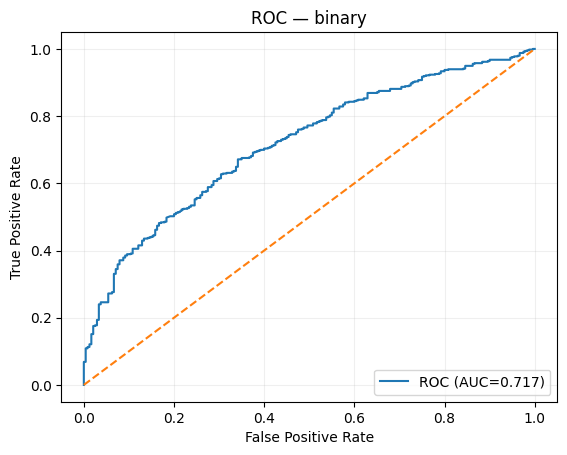

Val Loss: 0.5808  |  ROC-AUC: 0.7168

Classification report
              precision    recall  f1-score   support

           0     0.5926    0.1333    0.2177       240
           1     0.6950    0.9556    0.8048       496

    accuracy                         0.6875       736
   macro avg     0.6438    0.5445    0.5112       736
weighted avg     0.6616    0.6875    0.6133       736



In [35]:
metrics = evaluate_model(model, val_loader, criterion, device=device, multiclass=False, plot=True)

---

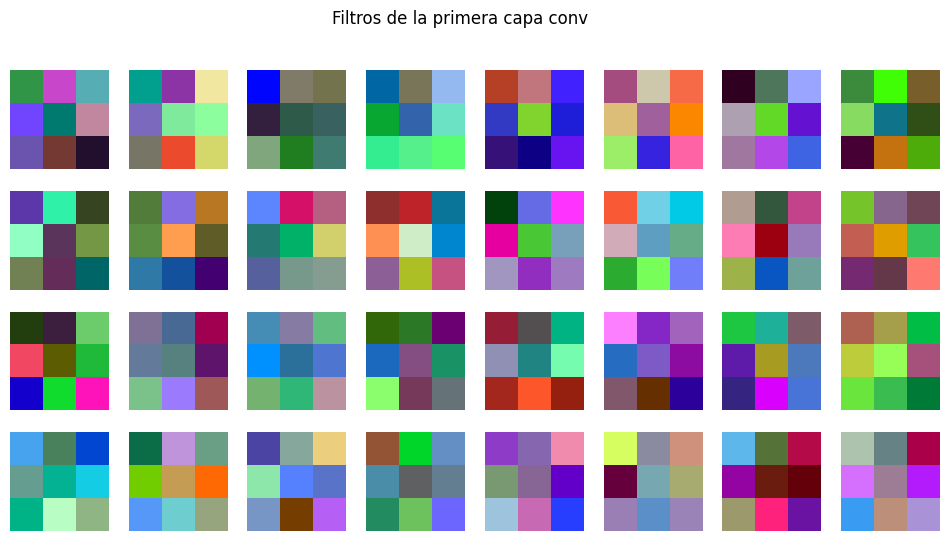

In [36]:
def show_first_layer_filters(model, max_filters=32):
    # buscamos la primera capa conv
    first_conv = None
    for m in model.modules():
        if isinstance(m, torch.nn.Conv2d):
            first_conv = m
            break

    if first_conv is None:
        raise ValueError("No se encontró capa Conv2d en el modelo")

    weights = first_conv.weight.data.clone().cpu()  # [out_c, in_c, k, k]
    n_filters = min(max_filters, weights.shape[0])
    plt.figure(figsize=(12, 6))
    for i in range(n_filters):
        f = weights[i]
        f = (f - f.min()) / (f.max() - f.min() + 1e-5)  # normalizar 0-1
        f = f.permute(1, 2, 0)  # [k, k, in_c]
        plt.subplot(4, n_filters//4, i+1)
        plt.imshow(f)
        plt.axis("off")
    plt.suptitle("Filtros de la primera capa conv")
    plt.show()

show_first_layer_filters(model, max_filters=32)

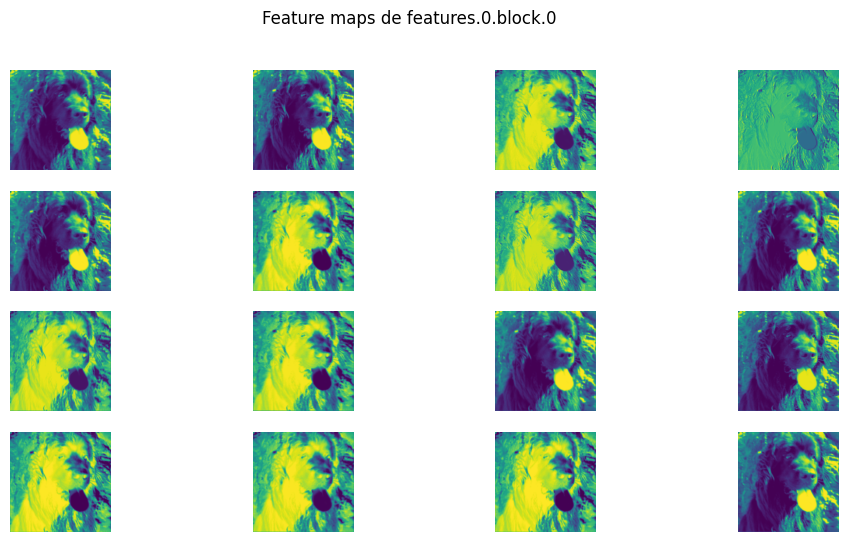

In [38]:
from torch.nn import Module

def show_feature_maps(model, layer_name, image, device="cuda", max_maps=16):
    """
    Visualiza activaciones (feature maps) de una capa específica.
    - layer_name: str con nombre de la capa (ej. 'features.0.block.0' si usas Sequential)
    - image: tensor [1,C,H,W] normalizado
    """
    activations = {}

    def hook_fn(module, inp, out):
        activations["feat"] = out.detach().cpu()

    layer = dict([*model.named_modules()])[layer_name]
    hook = layer.register_forward_hook(hook_fn)

    model.eval()
    _ = model(image.to(device))

    hook.remove()
    fmap = activations["feat"]

    n_maps = min(max_maps, fmap.shape[1])
    plt.figure(figsize=(12, 6))
    for i in range(n_maps):
        plt.subplot(4, n_maps//4, i+1)
        fm = fmap[0, i].numpy()
        fm = (fm - fm.min()) / (fm.max() - fm.min() + 1e-5)
        plt.imshow(fm, cmap="viridis")
        plt.axis("off")
    plt.suptitle(f"Feature maps de {layer_name}")
    plt.show()

xb, _ = next(iter(val_loader))
show_feature_maps(model, "features.0.block.0", xb[0].unsqueeze(0), device)

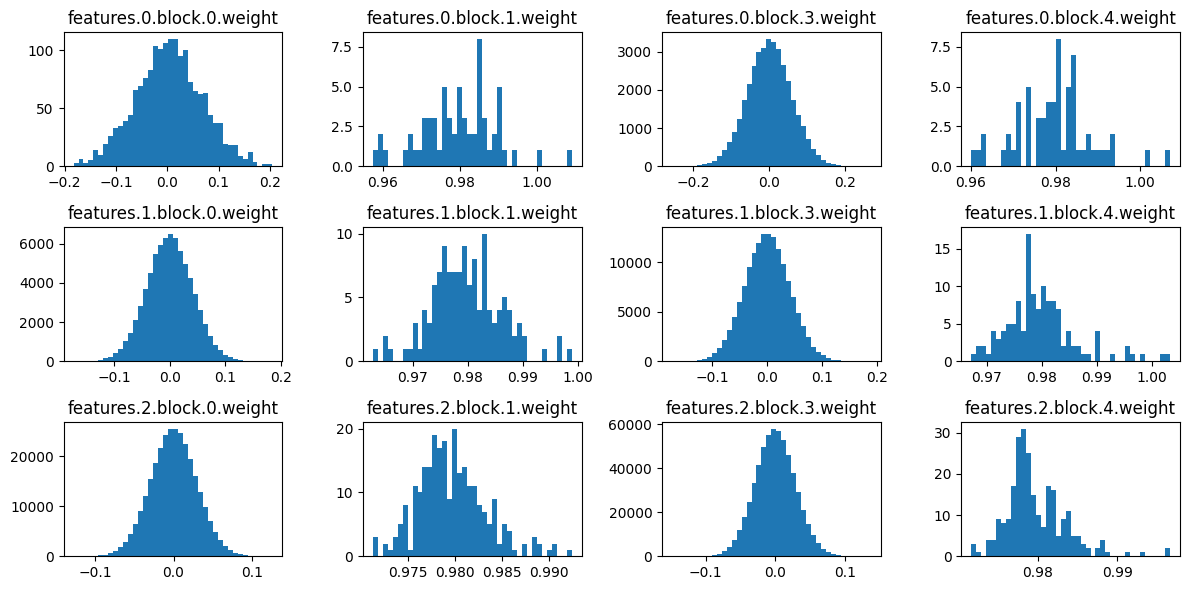

In [39]:
def plot_weight_histograms(model):
    plt.figure(figsize=(12,6))
    i = 1
    for name, param in model.named_parameters():
        if "weight" in name:
            plt.subplot(3,4,i)
            plt.hist(param.detach().cpu().numpy().ravel(), bins=40)
            plt.title(name)
            i += 1
            if i > 12: break
    plt.tight_layout()
    plt.show()


plot_weight_histograms(model)

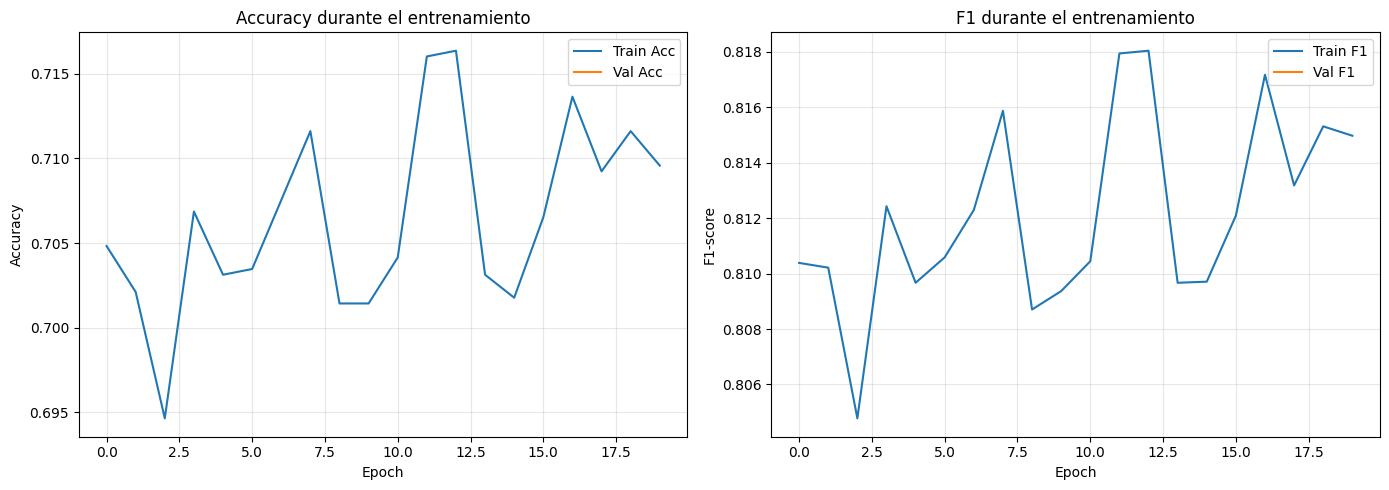

In [40]:
def plot_training_history(history):
    """
    history: dict con 'train_acc', 'val_acc', 'train_f1', 'val_f1' (como guardaste en tu loop)
    """
    plt.figure(figsize=(14,5))

    # Accuracy
    plt.subplot(1,2,1)
    plt.plot(history.get("train_acc", []), label="Train Acc")
    plt.plot(history.get("val_acc", []), label="Val Acc")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title("Accuracy durante el entrenamiento")
    plt.legend()
    plt.grid(True, alpha=0.3)

    # F1
    plt.subplot(1,2,2)
    plt.plot(history.get("train_f1", []), label="Train F1")
    plt.plot(history.get("val_f1", []), label="Val F1")
    plt.xlabel("Epoch")
    plt.ylabel("F1-score")
    plt.title("F1 durante el entrenamiento")
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

plot_training_history(history)

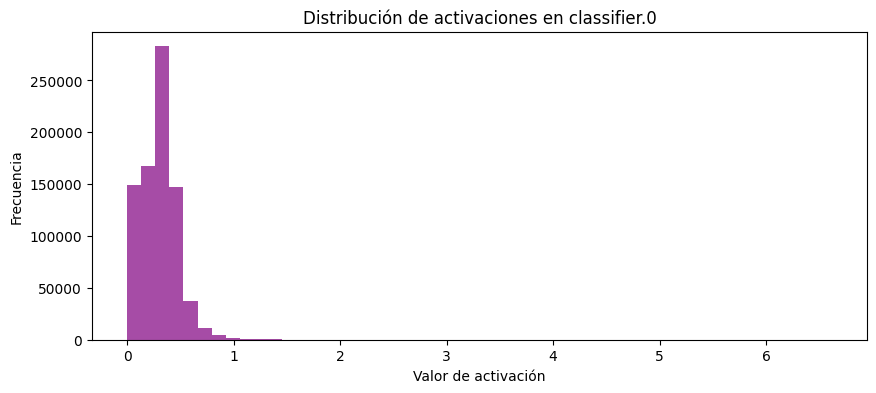

In [44]:
def plot_fc_activations(model, val_loader, device="cuda", layer_name="classifier.0"):
    """
    layer_name: nombre de la capa en model.named_modules()
    """
    activations = {}

    def hook_fn(module, inp, out):
        activations["feat"] = out.detach().cpu()

    layer = dict([*model.named_modules()])[layer_name]
    hook = layer.register_forward_hook(hook_fn)

    xb, _ = next(iter(val_loader))
    xb = xb.to(device)
    model.eval()
    _ = model(xb)

    hook.remove()
    feats = activations["feat"]  # [B, D]

    plt.figure(figsize=(10,4))
    plt.hist(feats.numpy().ravel(), bins=50, alpha=0.7, color="purple")
    plt.title(f"Distribución de activaciones en {layer_name}")
    plt.xlabel("Valor de activación")
    plt.ylabel("Frecuencia")
    plt.show()

plot_fc_activations(model, val_loader)